<a href="https://colab.research.google.com/github/purvikabajaj/Convolutional-Neural-Networks/blob/master/Transfer_Learning_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2020-08-22 09:44:46--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.96.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  72.3MB/s    in 0.9s    

2020-08-22 09:44:48 (72.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

In [ ]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [ ]:
train_cat_dir = os.path.join(train_dir, 'cats')
train_dog_dir = os.path.join(train_dir, 'dogs')

In [ ]:
validation_cat_dir = os.path.join(validation_dir, 'cats')
validation_dog_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.


In [ ]:
import matplotlib.pyplot as plt

(150, 150, 3)
(150, 150, 3)


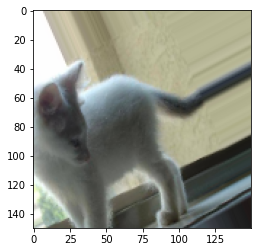

In [ ]:
x,y = train_generator.next()
for i in (0,1):
  image = x[i]
  plt.imshow(image)
  print(image.shape)

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1/255.0)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size = 20,
    target_size = (150,150),
    class_mode = 'binary'
)

Found 1000 images belonging to 2 classes.


(150, 150, 3)


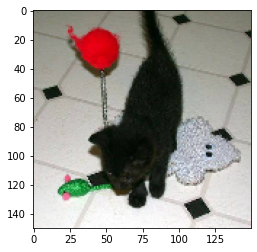

In [ ]:
x,y = validation_generator.next()
for i in range(0,1):
  image = x[i]
  plt.imshow(image)
  print(image.shape)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-08-22 09:44:54--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  48.2MB/s    in 1.7s    

2020-08-22 09:44:57 (48.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3 

In [ ]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
pre_trained_model = InceptionV3(
    input_shape = (150,150,3),
    include_top = False, #excluding top layers and going straight to convolutions
    weights = None
)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output
print('LAST LAYER OUTPUT SHAPE: ', last_layer.output_shape)

LAST LAYER OUTPUT SHAPE:  (None, 7, 7, 768)


In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 50
) 

Epoch 1/20
100/100 [==============================] - 18s 183ms/step - loss: 0.6630 - accuracy: 0.8685 - val_loss: 0.1206 - val_accuracy: 0.9510
Epoch 2/20
100/100 [==============================] - 17s 173ms/step - loss: 0.1930 - accuracy: 0.9250 - val_loss: 0.1186 - val_accuracy: 0.9570
Epoch 3/20
100/100 [==============================] - 17s 174ms/step - loss: 0.1815 - accuracy: 0.9310 - val_loss: 0.1237 - val_accuracy: 0.9550
Epoch 4/20
100/100 [==============================] - 18s 177ms/step - loss: 0.1844 - accuracy: 0.9245 - val_loss: 0.0924 - val_accuracy: 0.9620
Epoch 5/20
100/100 [==============================] - 18s 178ms/step - loss: 0.1755 - accuracy: 0.9275 - val_loss: 0.1545 - val_accuracy: 0.9360
Epoch 6/20
100/100 [==============================] - 18s 176ms/step - loss: 0.1486 - accuracy: 0.9375 - val_loss: 0.1025 - val_accuracy: 0.9620
Epoch 7/20
100/100 [==============================] - 18s 177ms/step - loss: 0.1491 - accuracy: 0.9420 - val_loss: 0.1216 - val_ac

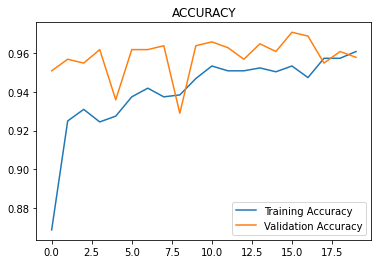

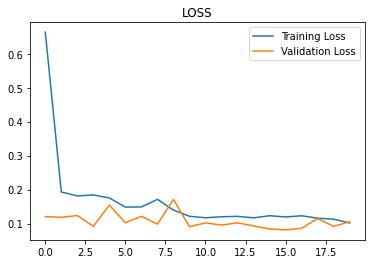

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('ACCURACY')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('LOSS')
plt.legend()